In [ ]:
import mantid.simpleapi as msapi
from mantid.simpleapi import *
from reduction_workflow.instruments.sans.hfir_command_interface import *



In [ ]:
!pip install matplotlib
# from mantid.simpleapi import *
# import mantid
# from mantid.simpleapi import *
# from reduction_workflow.instruments.sans.hfir_command_interface import *

# Import Libraries


In [1]:
import numpy as np
from math import pi, sin
import re
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from scipy.optimize import curve_fit

import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
#from dsans import dsans

os.chdir(r'C:\Users\Niels\Documents\AA Thesis\calibration')
print(glob.glob('*.mpa'))
files=glob.glob('*.mpa')
#sampledata=dsans('sans0002961.mpa')

#Sample to detector distance is FZZ +1320
#meetfile regel 7, FZZ, in mm

['sans0002961.mpa', 'sans000302.mpa', 'sans000308.mpa', 'sans000309.mpa']


# Import Functions

In [2]:
import numpy as np
def convertoq(distances, wavelength, d): #where in the convertiq function y_positions is set zero
    # Converts distances from the center to scattering vector magnitudes (q-values)
    # distances: array of distances from the center [m]
    # wavelength: wavelength of the beam in Angstrom
    # d: SDD [m]
    theta = np.arctan(distances / d) #calculate the scattering angle
    q_values = (4 * np.pi * np.sin(theta / 2) / wavelength) #Convert theta to q-values
    return q_values
        
def get_file(filename, batch=False):
    line=[]
    length=2105601
    with open(filename, "r") as file:
        for i in range(0,length):
            line.append(file.readline())
    return line  

def integerisation(data):
    length=np.size(data)
    #print(length)
    counts=[]
    for i in range(0,length):
        counts.append(int(data[i]))
    return counts
    
def det_distances(x, y, pixelx, pixely, center_X, center_Y, nrbins=100):
    # calculates the pixel locations and distances from the center
    # x, y: dimensions of the detector grid
    # pixelx, pixely: size of each pixel in meters
    # center_X, center_Y: coordinates of the center in pixels
    # nrbins: number of bins for the histogram of distances
    
    # Create position matrices and distance list
    matrix = np.zeros((y, x))
    x_positions = np.zeros((y, x))
    y_positions = np.zeros((y, x))
    distances_from_center = []
    angles = np.zeros((y, x))
    
    # Calculate positions and distances
    for i in range(y):
        for j in range(x):
            x_positions[i, j] = (j - center_X) * pixelx #calculate x position
            y_positions[i, j] = (i - center_Y) * pixely #calculate y poisition
            r = np.sqrt((x_positions[i, j]) ** 2 + (y_positions[i, j]) ** 2) #calculate distance from centre
            matrix[i, j] = r
            distances_from_center.append(r)
            angle = np.degrees(np.arctan2(y_positions[i, j], x_positions[i, j]))
            if angle < 0:
                angle += 360
            angles[i, j] = angle
    
    # Calculate unique distance values and their counts
    values, counts = np.unique(matrix, return_counts=True)
    
    center_y_index = int(center_Y)
    center_x_index = int(center_X)
    print(f"Center distance (center_Y, center_X): {matrix[center_y_index, center_x_index]}")
    
    # Calculate and print the maximum/ minimum distance
    max_distance = np.max(matrix)
    print(f"Maximum distance from center: {max_distance} meters")
    min_distance = np.min(matrix)
    print(f"Minimum distance from center: {min_distance} meters")
    
    # Generate bin edges for histogram
    bins1 = []
    for i in range(1, nrbins + 1):
        j = int(i ** (np.log(len(values)) / np.log((nrbins) + 1))) #calculate the bin index
        vall = values[j] #value for the bin edge
        bins1.append(vall)

    bins = np.asarray(bins1) #convert list as array
    
    #digitise the matrix and values to get the bin indices
    bin_indices_matrix = np.digitize(matrix, bins)
    bin_indices_values = np.digitize(values, bins)
    val_bin = np.unique(bin_indices_values, return_index=False, return_inverse=False, return_counts=False, axis=None)
    val_bin = val_bin[1::]  #Remove first bin (0)
    realval = []
    for i in range(0, nrbins):
        if i == 0:
            real = bins[0]
        else:
            real = (bins[i] + bins[i - 1]) / 2 # Average of adjacent bin edges
            realval.append(real)

    realval.append(values.max())
    realval = np.asarray(realval)
    
    # Print distances from the center to check for spherical symmetry
    distances_from_center = matrix
    # Reshape distances from center to 2D array
    distances_from_center = np.array(distances_from_center).reshape(y, x)   
    return val_bin, bin_indices_matrix, distances_from_center , x_positions, y_positions, angles


# def radial(data2, values, matrix, n_sectors=180):
#     #Calculates the radial average intensity
#     #data2: 2D array of intensity values
#     # Values: Distances
#     # matrix: 2D array of distances from the centre.
#     I = []
#     sector_intensities = [[] for _ in range(n_sectors)]
#     sector_angles = np.linspace(0, 360, n_sectors + 1)
    
#     for value in values:
#         # fined indices in matrix that match the current value
#         index_y, index_x = np.where(matrix == value)
#         if index_y.size == 0:
#             I.append(0)  # Append zero if no indices found for a value
#             continue

#         # Ensure indices are within data bounds
#         valid_indices = (index_y < data2.shape[0]) & (index_x < data2.shape[1])
#         index_y = index_y[valid_indices]
#         index_x = index_x[valid_indices]
    
#         if index_y.size == 0:
#             I.append(0)  # Append zero if no valid indices remain
#             continue
#         # Check the intensity values at these indices
#         intensity_values = data2[index_y, index_x]

#         # Sum all data points at the valid indices
#         summed_intensity = intensity_values.sum()
#         average_intensity = summed_intensity / index_y.size
#         I.append(average_intensity)

# #    print(f"Radial function results: {I}")
# #    print(f"Radial function shape results: {len(I)}")
#     return I

# def radial(data2, values, matrix, angles, n_sectors=180):
#     sector_intensities = [[] for _ in range(n_sectors)]
#     sector_angles = np.linspace(0, 360, n_sectors + 1)
    
#     # Calculate the intensity for each sector
#     for value in values:
#         index_y, index_x = np.where(matrix == value)
#         if index_y.size == 0:
#             continue
#         valid_indices = (index_y < data2.shape[0]) & (index_x < data2.shape[1])
#         index_y = index_y[valid_indices]
#         index_x = index_x[valid_indices]
#         if index_y.size == 0:
#             continue
        
#         intensity_values = data2[index_y, index_x]
#         angle_values = angles[index_y, index_x]
        
#         for sector in range(n_sectors):
#             sector_mask = (angle_values >= sector_angles[sector]) & (angle_values < sector_angles[sector + 1])
#             if np.any(sector_mask):
#                 sector_intensity = np.mean(intensity_values[sector_mask])
#                 sector_intensities[sector].append(sector_intensity)
    
#     sector_intensities = [np.array(intensities) for intensities in sector_intensities]
    
#     return sector_intensities
def radial(data2, values, matrix, angles, n_sectors):
        sector_intensities = [[] for _ in range(n_sectors)]
        sector_angles = np.linspace(0, 360, n_sectors + 1)

        # Calculate the intensity for each sector
        for value in values:
            index_y, index_x = np.where(matrix == value)
            if index_y.size == 0:
                continue
            valid_indices = (index_y < data2.shape[0]) & (index_x < data2.shape[1])
            index_y = index_y[valid_indices]
            index_x = index_x[valid_indices]
            if index_y.size == 0:
                continue

            intensity_values = data2[index_y, index_x]
            angle_values = angles[index_y, index_x]

            for sector in range(n_sectors):
                sector_mask = (angle_values >= sector_angles[sector]) & (angle_values < sector_angles[sector + 1])
                if np.any(sector_mask):
                    sector_intensity = np.mean(intensity_values[sector_mask])
                    sector_intensities[sector].append(sector_intensity)

        sector_intensities = [np.array(intensities) for intensities in sector_intensities]

        return sector_intensities

def solid_angle_correction(q, wavelength, d):
    # Calculate the solid angle correstion for calibration
    # q: q-values array of the scattering magnitude
    # d: wavelength in Angstrom
    
    # Convert q to sin(theta/2)
    sin_theta_over_2 = q * wavelength / (4 * np.pi)
    
    # Compute theta
    theta = 2 * np.arcsin(sin_theta_over_2)
    
    # Correction factor
    correction_factor = np.cos(theta / 2)**3
    return correction_factor


def intfromstr(string1):
    return int(re.search(r'\d+', string1).group())

# Class


In [76]:
import numpy as np
class dsans:
    def __init__(self, filename, title=None, textsize=12):
        # Initialization with detector settings and file loading
        self.filename = filename
        self.setup_detector_geometry()
        self.load_data(filename)
        self.process_data()
        self.velocity_selector_speed = self.load_velocity_selector()
        self.lam = self.calculate_lambda_from_velocity(self.velocity_selector_speed)  # Calculate lambda from velocity
        print(f"lamda: {self.lam}")
        # Define the ranges and beam stop information here
        self.x_ranges = [(400, 450), (450, 600)]
        self.y_ranges = [(200, 250), (250, 300)]
        self.beam_stop_range_x = (430, 480)
        self.beam_stop_range_y = (230, 260)
        # Initialize the attributes with default values
        self.delta_omega = 1.0  # Example value
        self.d_sample = 0.05     # Example value
        self.i0_lambda = 1.0    # Example value
        self.transmission_lambda = 1.0  # Example value
        # Define the distances based on the provided geometry (in mm)
        self.distances = {
            'D_to_DS': 1320 + 0,        # Distance from diaphragm to sample, + PosFzz
            'DS_to_S': 1320,     # Distance from DS to Sample
            'DS_to_KB3': 2802,    # Distance from Sample to KB3
            'DS_to_KB2': 4793,  # Distance from KB3 to KB2
            'DS_to_KB1': 8798,  # Distance from KB2 to KB1
            'DS_to_PB1': 11606  # Distance from KB1 to P01
        }
        # Define the apertures sizes (in mm) for each diaphragm
        self.apertures = {
            'D': 10,       # Aperture size for diaphragm D
            'DS': 10,      # Aperture size for DS
            'S': 10,       # Aperture size for Sample
            'KB3': 10,     # Aperture size for KB3
            'KB2': 10,     # Aperture size for KB2
            'KB1': 10,     # Aperture size for KB1
            'PB1': 10      # Aperture size for P01
        }

    def setup_detector_geometry(self):
        # Detector geometry setup
        self.ymin = 50
        self.ymax = 1024 - 50
        self.y = (1024-100)
        self.pixely = 0.5 / self.y #ypixel size [m]
        self.xmin = 275 
        self.xmax = 750
        self.x = 1024 - 275 - 274 #number of x pixels #changed from 225 to 275
        self.pixelx = 0.5 / self.x #xpixel size [m]
#        self.lam = 5.8# *10**(-10) #e-10 # Wavelength in meter
        self.d = (self.load_distance() +1320)/1000 # [m] 1320 is the offset
        self.n_sectors = 6
        #Sample to detector distance is FZZ +1320
        print(f"Pixel size X: {self.pixelx} m, Pixel size Y: {self.pixely} m")
        
    def load_distance(self):
        with open(self.filename, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 7:
                seventh_line = lines[6].strip()
                print(f"seventh line: {seventh_line}")
                # Assuming the distance is always 2.520 as per your requirement
                distance = float(seventh_line.split('=')[1])
                print(f"new distance1: {distance}")
                return distance
    
    def load_velocity_selector(self):
        with open(self.filename, 'r') as file:
            lines = file.readlines()
            if len(lines) >= 18:
                eighteenth_line = lines[17].strip()
                print(f"eighteenth line: {eighteenth_line}")
                velocity_selector_speed = int(eighteenth_line.split('=')[1])
                print(f"velocity selector speed: {velocity_selector_speed}")
                return velocity_selector_speed
    def calculate_lambda_from_velocity(self, velocity):
        rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100]) # from the test data
        wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])
        sorted_indices = np.argsort(rpm)
        sorted_wavelengths = wavelengths[sorted_indices]
        sorted_rpm = rpm[sorted_indices]
        
        # Linear fit function
        def linear_fit(x, a, b):
            return a / x + b
        
        # Perform linear fit
        popt, _ = curve_fit(linear_fit, sorted_rpm, sorted_wavelengths)
        interpolated_lambda = linear_fit(velocity, *popt)
        print(f"Interpolated lambda: {interpolated_lambda} Å for velocity {velocity} RPM")
        return interpolated_lambda

    def load_data(self, filename):
        # Assuming get_file, integerisation, and intfromstr are defined
        data = get_file(filename)
        offset = 29
        self.filename = filename
        self.sample = data[1]
        self.runtime = intfromstr(data[46])
        self.tdat0 = integerisation(data[248 + offset:1272 + offset])
        self.tdat1 = integerisation(data[1273 + offset:2297 + offset])
        self.tdat2 = integerisation(data[2298 + offset:3322 + offset])
        self.tdat3 = integerisation(data[3323 + offset:4347 + offset])
        self.cdat0 = integerisation(data[4348 + offset:5372 + offset])
        self.cdat1 = integerisation(data[5373 + offset:6397 + offset])
        cdat2 = integerisation(data[6398 + offset:1054974 + offset])
        cdat3 = integerisation(data[1054975 + offset:2103551 + offset])
        self.cdat2_2d = np.reshape(cdat2, (1024, 1024))
        self.cdat3_2d = np.reshape(cdat3, (1024, 1024))
        self.twod= np.transpose(self.cdat2_2d[self.xmin:self.xmax, self.ymin:self.ymax])
        # Center the twod data
        # Find the center using FWHM method
        self.find_center_by_fwhm()
        # Print the arrays and their shapes
        print(f"self.cdat2_2d shape: {self.cdat2_2d.shape}")
#        print(f"self.cdat2_2d: {self.cdat2_2d}")
        print(f"self.twod shape: {self.twod.shape}")
#        print(f"self.twod: {self.twod}")

    def process_data(self):
        self.i_s = np.sum(self.twod, axis=0) 
        # Any additional data processing
        pass
    
    def find_center_by_fwhm(self):
        """
        Calculate the FWHM for both x and y axes and determine the centers.
        """
        # Sum the intensity values over specific range around the center along the y and x-axis
        integrated_over_x = np.sum(self.twod[440:460, :], axis=0)
        integrated_over_y = np.sum(self.twod[:, 235:260], axis=1)
        
        # Smooth the integrated intensity values
        smoothed_x = gaussian_filter1d(integrated_over_x, sigma=1)
        smoothed_y = gaussian_filter1d(integrated_over_y, sigma=3)
        # Debug prints
#        print(f"Integrated over X (summed over Y-axis range 430-470): {integrated_over_x}")
#        print(f"Smoothed X: {smoothed_x}")
#        print(f"Integrated over Y (summed over X-axis range 230-280): {integrated_over_y}")
#        print(f"Smoothed Y: {smoothed_y}")

#        self.center_x, self.fwhm_x = self.calculate_fwhm(integrated_over_x)
#         self.center_y, self.fwhm_y = self.calculate_fwhm(integrated_over_y)
        # Calculate the center and FWHM for the y and x-axis
        self.center_x, self.fwhm_x = self.calculate_fwhm(smoothed_x, 'X')
        self.center_y, self.fwhm_y = self.calculate_fwhm(smoothed_y, 'Y')

        print(f"Center X in pixels: {self.center_x}, Center Y in pixels: {self.center_y}")
        # Check if valid centers and FWHM were found
        if self.center_x is None or self.center_y is None:
            raise ValueError("Failed to calculate center positions")        
        # Convert the center positions and FWHM to meters
        self.center_x_m = self.center_x * self.pixelx
        self.fwhm_x_m = self.fwhm_x * self.pixelx
        self.center_y_m = self.center_y * self.pixely
        self.fwhm_y_m = self.fwhm_y * self.pixely

        print(f"Center X in meters: {self.center_x_m}, Center Y in meters: {self.center_y_m}")
        
    def calculate_fwhm(self, data, axis_name):
        """
        Calculate the FWHM and the center.
        """
        max_intensity = np.max(data)  # Maximum intensity
        half_max_intensity = max_intensity / 2  # Half of max intensity

        # Find the first occurrence from left to right for the left half
        left_indices = np.where(data > half_max_intensity)[0]
        if len(left_indices) > 0:
            left_edge_index = left_indices[0]
        else:
            left_edge_index = None
            print("No indices found in the left half")

        # Find the first occurrence from right to left for the right half
        right_indices = np.where(data[::-1] > half_max_intensity)[0]
        if len(right_indices) > 0:
            right_edge_index = len(data) - right_indices[0] - 1
        else:
            right_edge_index = None
            print("No indices found in the right half")

        # Debug prints for indices
        print(f"Left edge index: {left_edge_index}")
        print(f"Right edge index: {right_edge_index}")

        if left_edge_index is not None and right_edge_index is not None:
            fwhm = right_edge_index - left_edge_index
            center_index = (left_edge_index + right_edge_index) / 2
            return center_index, fwhm
        return None, None

    def plot_integrated_intensity(self, data=None, axis=0, title='Integrated Intensity', filename=None):
        """
        Plot combined integrated intensities along both X and Y axes with both pixel and distance representations.
        """
        fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Arrange plots in 2 rows, 1 column

        # Plot integrated intensity along X-axis (summed over Y) in pixels
        data = self.twod
        integrated_intensity_x = np.sum(data, axis=0)
        integrated_intensity_y = np.sum(data, axis=1)

        ax = axes[0]
        x_values_pixels = np.arange(integrated_intensity_x.size)
        ax.plot(x_values_pixels, integrated_intensity_x)
        ax.axvline(self.center_x, color='red', linestyle='--', linewidth=1, label='Center')
        ax.axvline(self.center_x - self.fwhm_x / 2, color='blue', linestyle='--', linewidth=1, label='FWHM')
        ax.axvline(self.center_x + self.fwhm_x / 2, color='blue', linestyle='--', linewidth=1)
#        ax.set_xlim(200, 300)
        ax.set_title('Integrated Intensity over X-axis (Summed over Y)')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        # Plot integrated intensity along Y-axis (summed over X) in pixels
        ax = axes[1]
        y_values_pixels = np.arange(integrated_intensity_y.size)
        ax.plot(y_values_pixels, integrated_intensity_y)
        ax.axvline(self.center_y, color='red', linestyle='--', linewidth=1, label='Center')
        ax.axvline(self.center_y - self.fwhm_y / 2, color='blue', linestyle='--', linewidth=1, label='FWHM')
        ax.axvline(self.center_y + self.fwhm_y / 2, color='blue', linestyle='--', linewidth=1)
        ax.set_xlim(300, 600)
        ax.set_title('Integrated Intensity over Y-axis (Summed over X)')
        ax.set_xlabel('Y (pixels)')
        ax.set_ylabel('Integrated Intensity')
        ax.legend()

        plt.tight_layout()
        plt.show()
        
        

    
    def convert_iq(self):
        """ 
        Convert intensity data to scattering intensity I(q) and apply calibration crrections
        """
        #Calculate distances and positions
        self.val_bin, self.bin_indices_matrix, self.distances,self.x_positions, self.y_positions, self.angles = det_distances(self.x, self.y, self.pixelx, self.pixely, self.center_x, self.center_y,100)

        # Maximum distance from center
        max_distance = np.max(self.distances)
        print(f"Maximum distance from center: {max_distance} meters")
#        print(f"angles 1: {self.angles}")
        print(f"angles 1 shape: {self.angles.shape}")
        
        self.iq = radial(self.twod, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)  # Calculate the radial average intensity I(q)
        print(f"iq length: {len(self.iq)}")
#        for i, element in enumerate(self.iq):
#            print(f"iq element {i} length: {len(element)}")
        #print(f"iq: {self.iq}")
        # Find the minimum length among the elements
        min_length = min(len(element) for element in self.iq)
        print(f"Minimum length: {min_length}")

        # Trim each element to the minimum length
        self.iq = [element[:min_length] for element in self.iq]
#        print(f"Trimmed iq: {[len(element) for element in self.iq]}")

        # Convert iq to numpy array for further processing
        self.iq = np.array(self.iq)
        print(f"iq shape after trimming: {self.iq.shape}")

        # Flatten distances for q-value calculation
        flat_distances = self.distances.flatten()
        pixel_q_values = convertoq(flat_distances, self.lam, self.d) #, y=0 as these are already the distances
        print(f"All q values shape: {pixel_q_values.shape}")

        # Reshape pixel_q_values to match the detector matrix
        pixel_q_values_reshaped = pixel_q_values.reshape(self.distances.shape)
        print(f"Reshaped q values shape: {pixel_q_values_reshaped.shape}")

        # Radially average the q values
        self.q = radial(pixel_q_values_reshaped, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)
        print(f"q length: {len(self.q)}")
#        for i, element in enumerate(self.q):
#            print(f"q element {i} length: {len(element)}")

        # Find the minimum length among the elements in q
        min_length_q = min(len(element) for element in self.q)
        print(f"Minimum q length: {min_length_q}")

        # Trim each element in q to the minimum length
        self.q = [element[:min_length_q] for element in self.q]
        print(f"Trimmed q: {[len(element) for element in self.q]}")
        
        self.q = np.array(self.q) # Ensure self.q is a numpy array
        #print(f"Radially averaged q: {self.q}")
        print(f"shape q: {np.shape(self.q)}")
        # Check if self.q is correctly formatted

        
        # Calculate the correction factors for each pixel's q value
        pixel_correction_factors = solid_angle_correction(pixel_q_values_reshaped, self.lam, self.d)
        print(f"Pixel-wise correction factors shape: {pixel_correction_factors.shape}")

        # Radially average the correction factors
        radial_correction_factors = radial(pixel_correction_factors, self.val_bin, self.bin_indices_matrix, self.angles, self.n_sectors)
        radial_correction_factors = np.array(radial_correction_factors)
#        print(f"Radially averaged correction factors: {radial_correction_factors}")
        print(f"radial_correction_factors length: {len(radial_correction_factors)}")
#        for i, element in enumerate(radial_correction_factors):
#            print(f"radial_correction_factors element {i} length: {len(element)}")
        # Ensure self.q and radial_correction_factors are 1D numpy arrays
        # Find the minimum length among the elements in radial_correction_factors
        min_length_rcf = min(len(element) for element in radial_correction_factors)
        print(f"Minimum radial_correction_factors length: {min_length_rcf}")

        # Trim each element in radial_correction_factors to the minimum length
        radial_correction_factors = [element[:min_length_rcf] for element in radial_correction_factors]
        print(f"Trimmed radial_correction_factors: {[len(element) for element in radial_correction_factors]}")

        # Convert radial_correction_factors to numpy array for further processing
        radial_correction_factors = np.array(radial_correction_factors)
        print(f"shape radial_correction_factors after trimming: {radial_correction_factors.shape}")

        # Compute corrected intensities
        self.iq_corrected = np.array([iq / radial_correction_factors[i] for i, iq in enumerate(self.iq)])
        print(f"iq_corrected shape: {self.iq_corrected.shape}")
       
        # Calculate maximum averaged radial distance
        max_averaged_radial_distance = self.calculate_max_averaged_radial_distance(self.distances, self.bin_indices_matrix)
        print(f"Maximum averaged radial distance: {max_averaged_radial_distance} meters")
        

    def calculate_max_averaged_radial_distance(self, distances, bin_indices_matrix):
        """
        Calculate the maximum averaged radial distance.
        """
        unique_bins = np.unique(bin_indices_matrix)
        max_averaged_distance = 0
        for bin_index in unique_bins:
            indices = np.where(bin_indices_matrix == bin_index)
            average_distance = np.mean(distances[indices])
            if average_distance > max_averaged_distance: 
                max_averaged_distance = average_distance # Update the maximum averaged distance if the current average is greater
        return max_averaged_distance
            
    def plot_2d(self, writepdf=False, filename='2dplot.pdf'):
        """
        Plot the 2D intensity data.
        """
        norm = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.show()
        plt.figure()
        plt.pcolormesh(self.twod, norm=norm, shading='gouraud')
        plt.colorbar(label='Intensity')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.xlim(200, 300)
        plt.ylim(350, 600)
        if writepdf:
            plt.savefig(filename)
        plt.show()
        
    def calculate_absolute_intensity(self):
        """
        Calculate the absolute intensity (Macroscopic scattering cross section) of the scattering data.
        """
        print(f"delta_omega: {self.delta_omega}, i0_lambda: {self.i0_lambda}, transmission_lambda: {self.transmission_lambda}, d_sample: {self.d_sample}")
        self.absolute_intensity = np.array(self.iq_corrected) / (self.delta_omega * self.i0_lambda * self.transmission_lambda * self.d_sample)
    #    print(f"absolute_intensity: {self.absolute_intensity}")
        print(f"absolute_intensity shape: {self.absolute_intensity.shape}")
        
    def radial_average_absolute_intensity(self):
        """
        Calculate the radial average of the absolute intensity for each sector.
        """
        num_sectors = self.n_sectors
        min_length = self.absolute_intensity.shape[1]

        # Initialize arrays to hold the radial average and count for each sector
        radial_average = np.zeros((num_sectors, min_length))
        count = np.zeros((num_sectors, min_length))

        # Calculate the radial average for each sector
        for sector in range(num_sectors):
            for i in range(min_length):
                radial_average[sector, i] += self.absolute_intensity[sector, i]
                count[sector, i] += 1

        # Compute the average, avoiding division by zero
        self.absolute_intensity_avg = np.divide(radial_average, count, out=np.zeros_like(radial_average), where=count != 0)
        # Check the shapes
        print(f"Shape of self.q: {self.q.shape}")
        print(f"Shape of absolute_intensity_avg: {self.absolute_intensity_avg.shape}")
 
        
    def calculate_divergence_angle(self, aperture_size, distance):
        if distance == 0:
            return 0
        return np.arctan(aperture_size / (2 * distance))
    
    def calculate_beam_divergence(self):
        divergence_angles = {}
        previous_aperture_size = self.apertures['D']
        for key, distance in self.distances.items():
            divergence_angles[key] = self.calculate_divergence_angle(previous_aperture_size, distance)
        return divergence_angles 


    def plot_scattering_cross_section(self,combined_sectors):
        if not hasattr(self, 'absolute_intensity_avg') or not hasattr(self, 'q'):
            raise ValueError("Absolute intensity or q-values are not calculated.")

        # Check the shapes to ensure they are compatible
        if self.q.shape != self.absolute_intensity_avg.shape:
            raise ValueError(f"Shape mismatch: q has shape {self.q.shape}, while absolute_intensity_avg has shape {self.absolute_intensity_avg.shape}")

        num_sectors = self.q.shape[0]
        plt.figure(figsize=(10, 6))

        # Plot each sector's data
        for sector_range in combined_sectors:
            for sector in range(sector_range[0], sector_range[1] + 1):
                if sector < num_sectors:
                    plt.plot(self.q[sector], self.absolute_intensity_avg[sector], label=f'Sector {sector + 1}')

        plt.title('Scattering Cross Section vs. Q-Value')
        plt.xlabel('Q-Value (1/Å)')
        plt.ylabel('Scattering Cross Section')
        plt.yscale('log')
        plt.xscale('log')
        plt.grid(True)
        plt.legend()
        plt.show()
    

    def plot_qx_qy(self, combined_sectors):
        """
        Plot Qx vs Qy maps and scatter plots with logarithmic intensity scale.
        """
        # Use the det_distances function to calculate the positions and distances
        self.val_bin, self.bin_indices_matrix, self.distances, self.x_positions, self.y_positions, self.angles = det_distances(
            self.x, self.y, self.pixelx, self.pixely, self.center_x, self.center_y)

        # Calculate qx and qy values using the convertoq function
        qx = convertoq(self.x_positions, self.lam, self.d)
        qy = convertoq(self.y_positions, self.lam, self.d)

        # Debug statements
        print(f"x_positions shape: {self.x_positions.shape}")
        print(f"y_positions shape: {self.y_positions.shape}")
        print(f"qx shape: {qx.shape}")
        print(f"qy shape: {qy.shape}")   

        extent_x = (-(self.center_x * self.pixelx), (self.x - self.center_x) * self.pixelx)
        extent_y = (-(self.center_y * self.pixely), (self.y - self.center_y) * self.pixely)

        plt.figure(figsize=(20, 8))

        plt.figure(figsize=(10, 8))
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))
        scatter = plt.scatter(qx, qy, c=self.twod, cmap='viridis', s=1, norm=norm1)
        plt.colorbar(scatter, label='Intensity')
        plt.title('Qx vs Qy reshaped')
        plt.xlabel('Qx (1/Å)')
        plt.ylabel('Qy (1/Å)')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 10))
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Plotting the centered 2D data using imshow
        im = plt.imshow(self.twod, cmap='viridis', norm=norm1, origin='lower')
        plt.scatter(np.array([self.center_x]), np.array([self.center_y]), color='red', s=100, marker='x', label='Center Point')

        # Plot the cross
        plt.axvline(x=self.center_x, color='red', linestyle='-', linewidth=1)
        plt.axhline(y=self.center_y, color='red', linestyle='-', linewidth=1)

        plt.title('Centered 2D Data with Extent in Pixels')
        plt.xlabel('X (pixels)')
        plt.ylabel('Y (pixels)')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Plot Qx vs Qy for combined sectors
        plt.figure(figsize=(10, 8))
        norm2 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Filter qx and qy based on combined sectors
        for sector_range in combined_sectors:
            for sector in range(sector_range[0], sector_range[1] + 1):
                sector_mask = (self.angles >= (sector - 1) * (360 / self.n_sectors)) & (self.angles < sector * (360 / self.n_sectors))
                plt.scatter(qx[sector_mask], qy[sector_mask], c=self.twod[sector_mask], cmap='viridis', s=1, norm=norm2)

        plt.colorbar(label='Intensity')
        plt.title('Qx vs Qy for Combined Sectors')
        plt.xlabel('Qx (1/Å)')
        plt.ylabel('Qy (1/Å)')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(8, 8))  # Adjust figsize to make the plot square
        norm1 = mcolors.LogNorm(vmin=np.min(self.twod[self.twod > 0]), vmax=np.max(self.twod))

        # Calculate extent in meters
        extent = [-(self.center_x * self.pixelx), (self.x - self.center_x) * self.pixelx, 
                  -(self.center_y * self.pixely), (self.y - self.center_y) * self.pixely]
        
        # Calculate center position in meters
        center_x_m = (self.center_x - self.x / 2) * self.pixelx
        center_y_m = (self.center_y - self.y / 2) * self.pixely
        
        # Plotting the centered 2D data using imshow with extent in meters
        im = plt.imshow(self.twod, cmap='viridis', norm=norm1, origin='lower', extent=extent)
        plt.scatter([center_x_m], [center_y_m], color='red', s=100, marker='x', label='Center Point')

        # Plot the cross in meters
        plt.axvline(x=center_x_m, color='red', linestyle='-', linewidth=1)
        plt.axhline(y=center_y_m, color='red', linestyle='-', linewidth=1)

        plt.title('Centered 2D Data with Extent in Meters')
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
        plt.show()


       
        
        
        
    


# Run the code

['sans000392.mpa', 'sans000393.mpa', 'sans000394.mpa', 'sans000395.mpa', 'sans000396.mpa', 'sans000397.mpa', 'sans000398.mpa', 'sans000399.mpa', 'sans000400.mpa', 'sans000401.mpa', 'sans000402.mpa', 'sans000403.mpa', 'sans000404.mpa', 'sans000405.mpa', 'sans000406.mpa', 'sans000407.mpa', 'sans000408.mpa', 'sans000409.mpa', 'sans000410.mpa', 'sans000411.mpa', 'sans000413.mpa', 'sans000414.mpa', 'sans000415.mpa']
seventh line: FZZ=3422.98528
new distance1: 3422.98528
Pixel size X: 0.0010526315789473684 m, Pixel size Y: 0.0005411255411255411 m
Left edge index: 225
Right edge index: 260
Left edge index: 406
Right edge index: 486
Center X in pixels: 242.5, Center Y in pixels: 446.0
Center X in meters: 0.25526315789473686, Center Y in meters: 0.24134199134199133
self.cdat2_2d shape: (1024, 1024)
self.twod shape: (924, 475)
eighteenth line: SpeedVS=21202
velocity selector speed: 21202
Interpolated lambda: 5.997383326898995 Å for velocity 21202 RPM
lamda: 5.997383326898995
Left edge index: 225

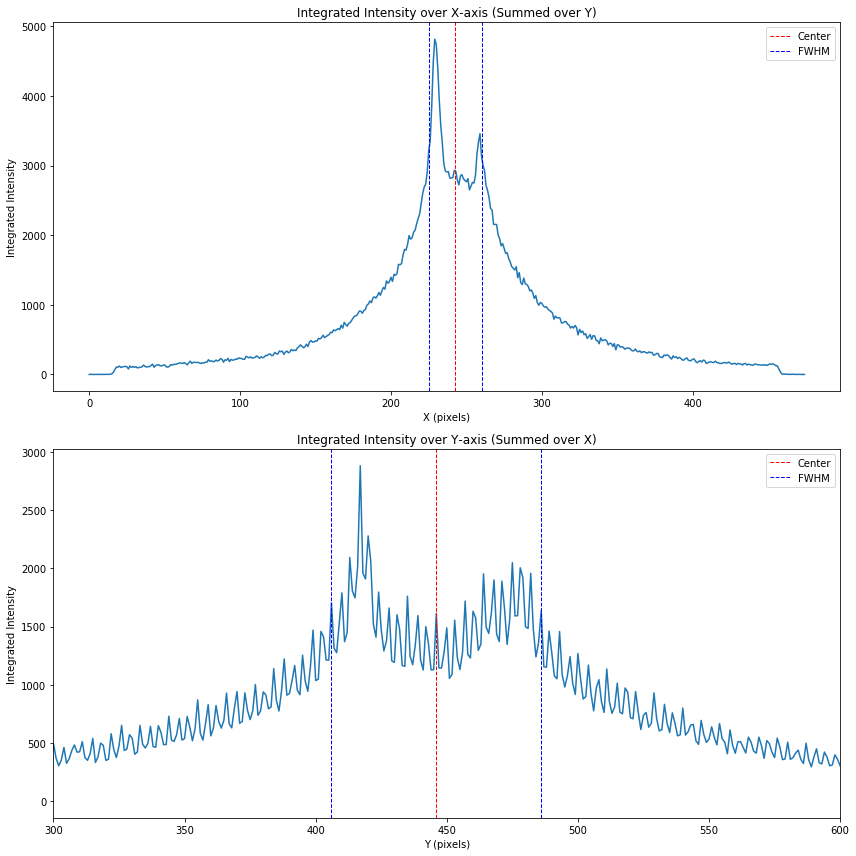

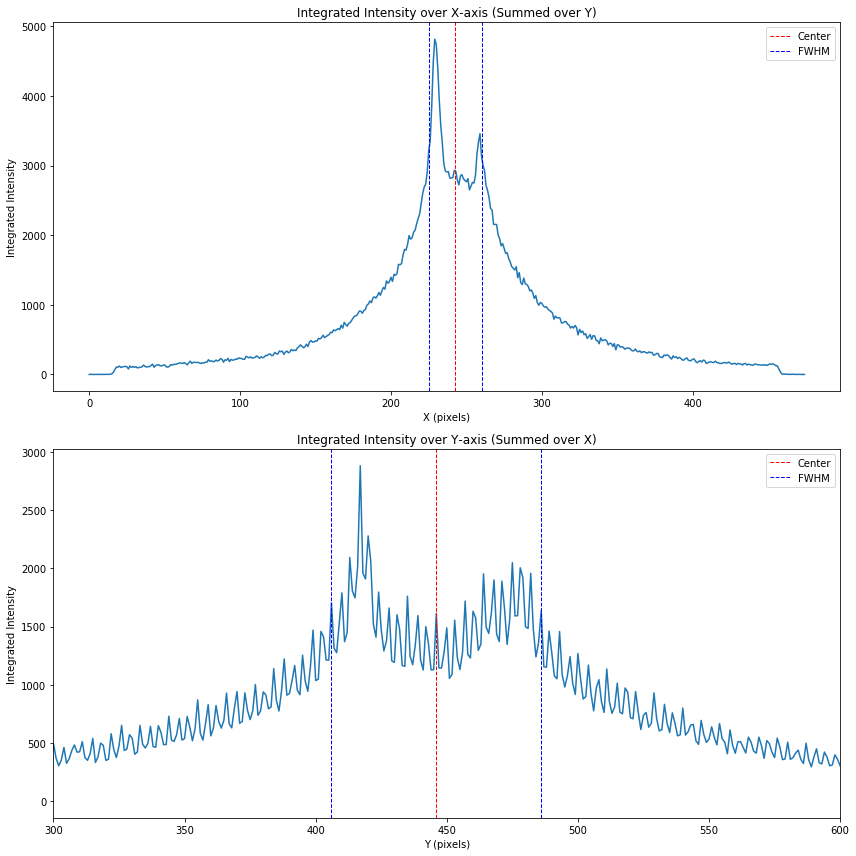

Center distance (center_Y, center_X): 0.0005263157894736842
Maximum distance from center: 0.3630201166992927 meters
Minimum distance from center: 0.0005263157894736842 meters
Maximum distance from center: 0.3630201166992927 meters
angles 1 shape: (924, 475)
iq length: 6
Minimum length: 95
iq shape after trimming: (6, 95)
All q values shape: (438900,)
Reshaped q values shape: (924, 475)
q length: 6
Minimum q length: 95
Trimmed q: [95, 95, 95, 95, 95, 95]
shape q: (6, 95)
Pixel-wise correction factors shape: (924, 475)
radial_correction_factors length: 6
Minimum radial_correction_factors length: 95
Trimmed radial_correction_factors: [95, 95, 95, 95, 95, 95]
shape radial_correction_factors after trimming: (6, 95)
iq_corrected shape: (6, 95)
Maximum averaged radial distance: 0.33482595118106256 meters


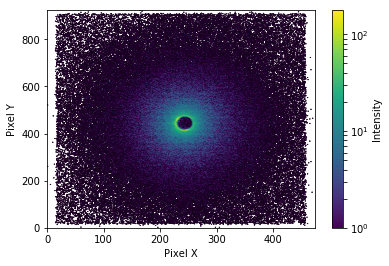

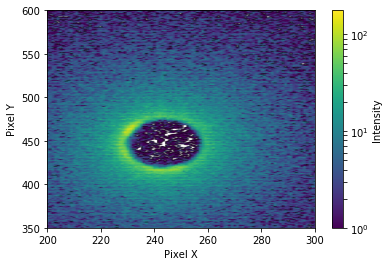

delta_omega: 1.0, i0_lambda: 1.0, transmission_lambda: 1.0, d_sample: 0.05
absolute_intensity shape: (6, 95)
Shape of self.q: (6, 95)
Shape of absolute_intensity_avg: (6, 95)


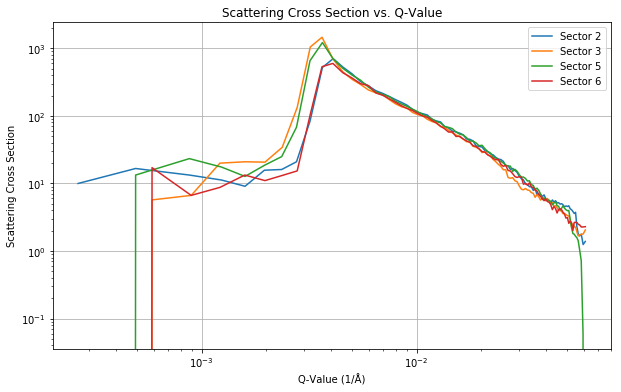

Center distance (center_Y, center_X): 0.0005263157894736842
Maximum distance from center: 0.3630201166992927 meters
Minimum distance from center: 0.0005263157894736842 meters
x_positions shape: (924, 475)
y_positions shape: (924, 475)
qx shape: (924, 475)
qy shape: (924, 475)


<Figure size 1440x576 with 0 Axes>

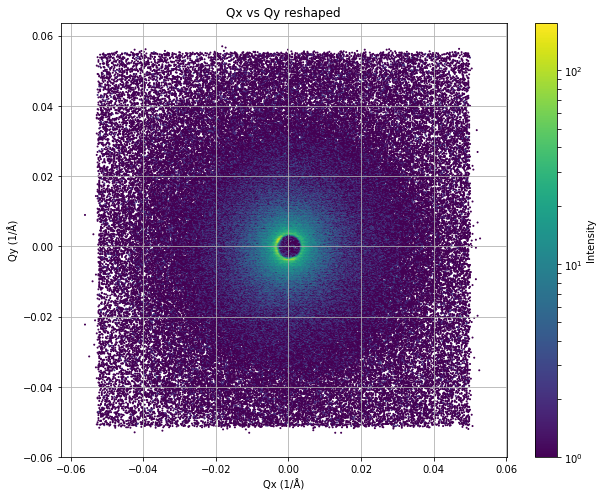

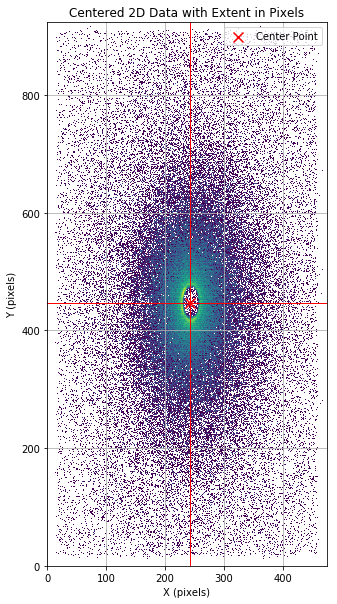

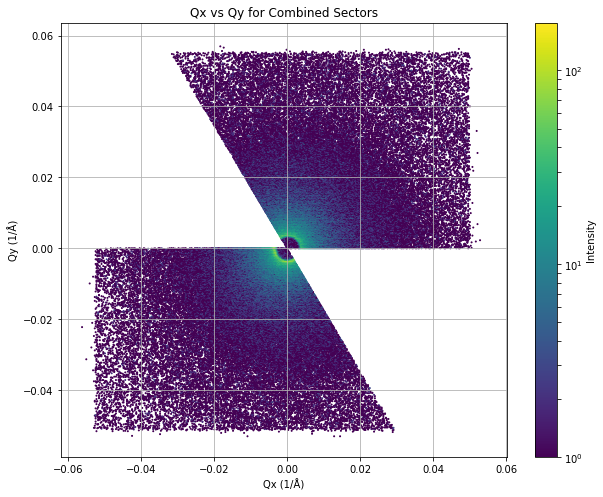

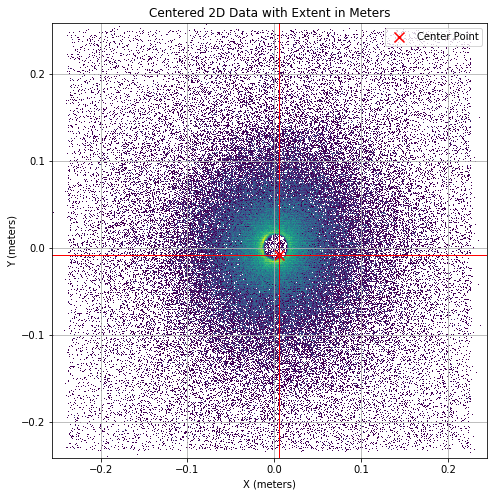

In [80]:
# Load data set(s)
# os.chdir('C:/Users/wbouwman/OneDrive - Delft University of Technology/Documents/Mydata/SANS')

os.chdir(r'C:\Users\Niels\Documents\AA Thesis\calibration\28_05_2024')
print(glob.glob('*.mpa'))
files=glob.glob('*.mpa')
sampledata = dsans('sans000400.mpa')

# Load data and process it
sampledata.find_center_by_fwhm()

print(f"X Center: {sampledata.center_x}, X FWHM: {sampledata.fwhm_x}")
print(f"Y Center: {sampledata.center_y}, Y FWHM: {sampledata.fwhm_y}")
# Plot the integrated intensity along the X-axis (summed over Y)
sampledata.plot_integrated_intensity(axis=0, title='Integrated Intensity over X-axis')

# Plot the integrated intensity along the Y-axis (summed over X)
sampledata.plot_integrated_intensity(axis=1, title='Integrated Intensity over Y-axis')
sampledata.convert_iq()
# Plot the 2D intensity data
sampledata.plot_2d()

# Calculate the absolute intensity
sampledata.calculate_absolute_intensity()

# Perform radial averaging on the absolute intensity
sampledata.radial_average_absolute_intensity()

# Plot the scattering cross section vs. q-value
combined_sectors = [(1, 2), (4, 5)]
sampledata.plot_scattering_cross_section(combined_sectors)
sampledata.plot_qx_qy(combined_sectors)


# Plot the integrated intensity along x-axis (summed over y)
#sampledata.plot_integrated_intensity(axis=0)

# Plot the integrated intensity along y-axis (summed over x)
#sampledata.plot_integrated_intensity(axis=1)

#sampledata.plot_qx_qy()
# Plot qx vs qy with sector cuts






# test cell

In [ ]:
sigma_x, sigma_y = 10000, 10000 

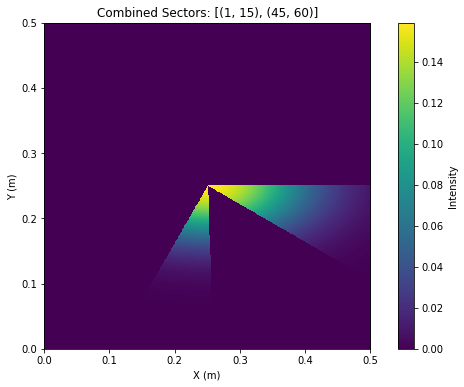

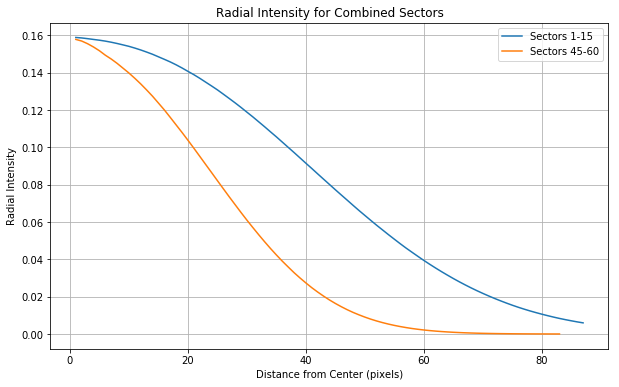

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Function to generate Gaussian data
def generate_gaussian_data(y, x, center_X, center_Y, sigma_x, sigma_y, peak_intensity):
    x_vals = np.linspace(0, x - 1, x)
    y_vals = np.linspace(0, y - 1, y)
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)
    
    pos = np.dstack((x_grid, y_grid))
    rv = multivariate_normal([center_X, center_Y], [[sigma_x, 0], [0, sigma_y]])
    data = peak_intensity * rv.pdf(pos)
    
    return data

# Function to calculate distances, positions, and angles
def det_distances(x, y, pixelx, pixely, center_X, center_Y, nrbins=100):
    matrix = np.zeros((y, x))
    x_positions = np.zeros((y, x))
    y_positions = np.zeros((y, x))
    distances_from_center = []
    angles = np.zeros((y, x))  # To store angles
    
    # Calculate distances and angles for each pixel
    for i in range(y):
        for j in range(x):
            x_positions[i, j] = (j - center_X) * pixelx
            y_positions[i, j] = (i - center_Y) * pixely
            r = np.sqrt((x_positions[i, j]) ** 2 + (y_positions[i, j]) ** 2)
            matrix[i, j] = r
            distances_from_center.append(r)
            angle = np.degrees(np.arctan2(y_positions[i, j], x_positions[i, j]))
            if angle < 0:
                angle += 360
            angles[i, j] = angle
    
    # Calculate unique distance values and their counts
    values, counts = np.unique(matrix, return_counts=True)
    bins1 = [values[int(i ** (np.log(len(values)) / np.log(nrbins + 1)))] for i in range(1, nrbins + 1)]
    bins = np.asarray(bins1)
    bin_indices_matrix = np.digitize(matrix, bins)
    bin_indices_values = np.digitize(values, bins)
    val_bin = np.unique(bin_indices_values)[1:]
    realval = [(bins[i] + bins[i - 1]) / 2 for i in range(1, nrbins)]
    realval = np.asarray(realval + [values.max()])
    
    return val_bin, bin_indices_matrix, matrix, x_positions, y_positions, angles

# Function to calculate radial intensity for each sector
def sector_radial(data2, values, matrix, angles, n_sectors=180):
    sector_intensities = [[] for _ in range(n_sectors)]
    sector_angles = np.linspace(0, 360, n_sectors + 1)
    
    # Calculate the intensity for each sector
    for value in values:
        index_y, index_x = np.where(matrix == value)
        if index_y.size == 0:
            continue
        valid_indices = (index_y < data2.shape[0]) & (index_x < data2.shape[1])
        index_y = index_y[valid_indices]
        index_x = index_x[valid_indices]
        if index_y.size == 0:
            continue
        
        intensity_values = data2[index_y, index_x]
        angle_values = angles[index_y, index_x]
        
        for sector in range(n_sectors):
            sector_mask = (angle_values >= sector_angles[sector]) & (angle_values < sector_angles[sector + 1])
            if np.any(sector_mask):
                sector_intensity = np.mean(intensity_values[sector_mask])
                sector_intensities[sector].append(sector_intensity)
    
    sector_intensities = [np.array(intensities) for intensities in sector_intensities]
    
    return sector_intensities

# Function to trim arrays to the length of the shortest array
def trim_to_min_length(arrays):
    min_length = min(len(arr) for arr in arrays)
    trimmed_arrays = [arr[:min_length] for arr in arrays]
    return np.array(trimmed_arrays)

# Function to plot combined sectors intensity distributions
def plot_combined_sectors(data, angles, combined_sectors, pixelx, pixely):
    combined_mask = np.zeros_like(data, dtype=bool)
    
    # Combine the masks for the selected sectors
    for start_sector, end_sector in combined_sectors:
        for sector in range(start_sector, end_sector + 1):
            sector_mask = (angles >= (sector - 1) * 2) & (angles < sector * 2)
            combined_mask |= sector_mask
    
    # Plot the combined intensity distribution
    plt.figure(figsize=(10, 6))
    plt.imshow(data * combined_mask, cmap='viridis', extent=[0, data.shape[1] * pixelx, 0, data.shape[0] * pixely])
    plt.colorbar(label='Intensity')
    plt.title(f'Combined Sectors: {combined_sectors}')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Function to plot radial intensity for combined sectors
def plot_radial_intensity(sector_intensities, val_bin, combined_sectors):
    plt.figure(figsize=(10, 6))
    
    # Calculate and plot the combined radial intensity for selected sectors
    for start_sector, end_sector in combined_sectors:
        selected_intensities = [sector_intensities[sector - 1] for sector in range(start_sector, end_sector + 1) if len(sector_intensities[sector - 1]) > 0]
        if selected_intensities:
            trimmed_intensities = trim_to_min_length(selected_intensities)
            combined_intensity = np.mean(trimmed_intensities, axis=0)
            plt.plot(val_bin[:len(combined_intensity)], combined_intensity, label=f'Sectors {start_sector}-{end_sector}')
    
    plt.title('Radial Intensity for Combined Sectors')
    plt.xlabel('Distance from Center (pixels)')
    plt.ylabel('Radial Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define initial parameters
y, x = 924, 475
pixelx, pixely = 0.5 / x, 0.5 / y
center_X, center_Y = x / 2, y / 2
sigma_x, sigma_y = 10000, 10000
peak_intensity = 10000

# Generate Gaussian data
data = generate_gaussian_data(y, x, center_X, center_Y, sigma_x, sigma_y, peak_intensity)

# Calculate distances, positions, and angles
val_bin, bin_indices_matrix, distances_from_center, x_positions, y_positions, angles = det_distances(x, y, pixelx, pixely, center_X, center_Y)

# Perform sector cuts and radial intensity calculations
sector_intensities = sector_radial(data, val_bin, bin_indices_matrix, angles, n_sectors=180)

# Define combined sectors to plot
combined_sectors = [(1, 15), (45, 60)]

# Plot combined sectors intensity distributions
plot_combined_sectors(data, angles, combined_sectors, pixelx, pixely)

# Plot radial intensity for combined sectors
plot_radial_intensity(sector_intensities, val_bin, combined_sectors)


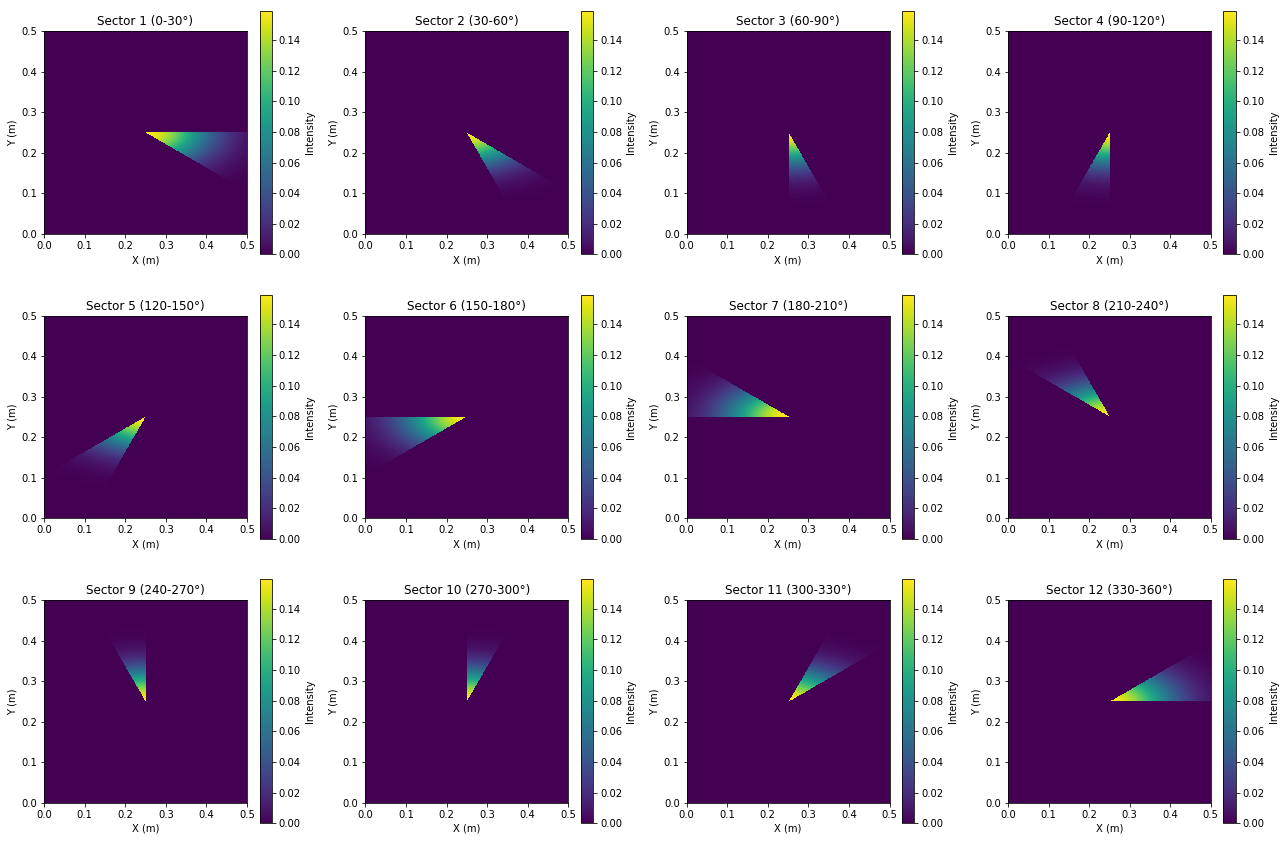

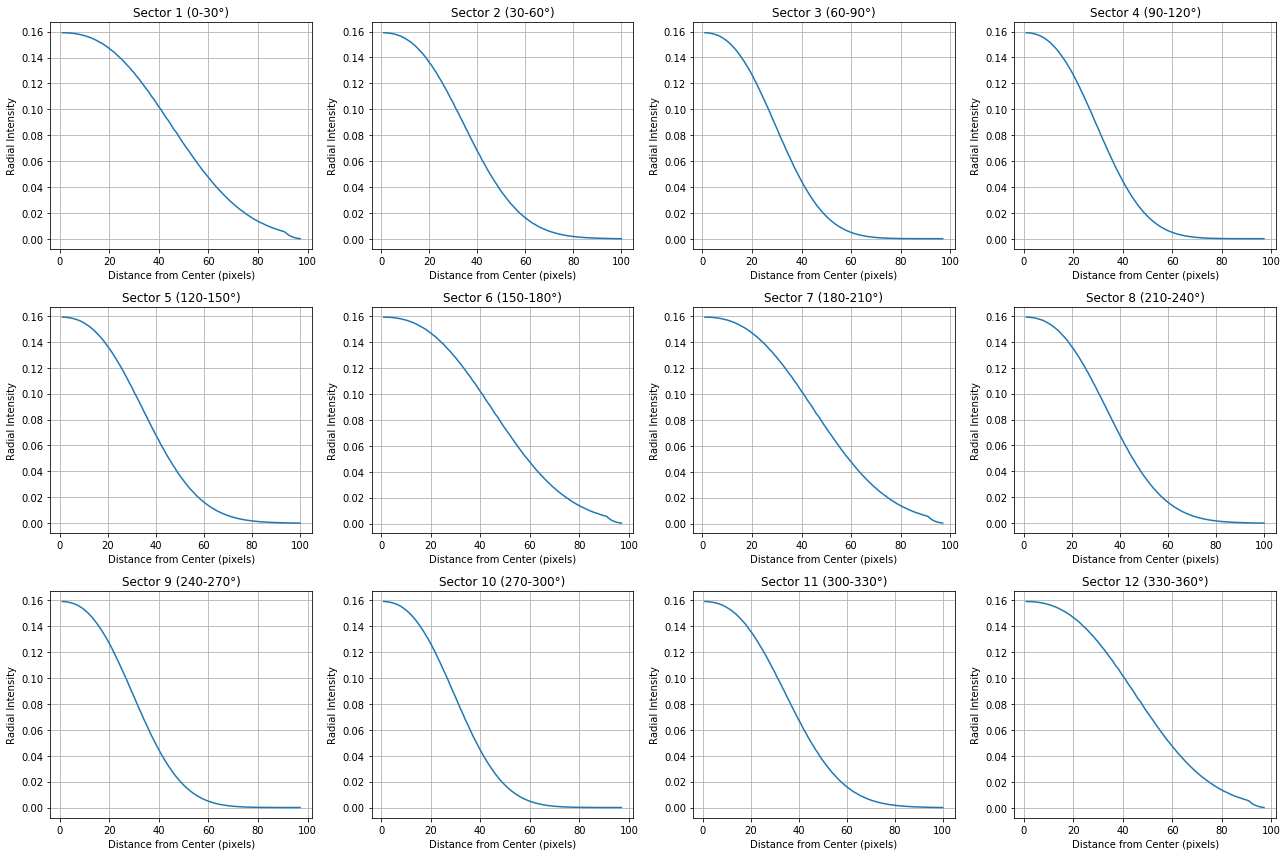

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def generate_gaussian_data(y, x, center_X, center_Y, sigma_x, sigma_y, peak_intensity):
    x_vals = np.linspace(0, x - 1, x)
    y_vals = np.linspace(0, y - 1, y)
    x_grid, y_grid = np.meshgrid(x_vals, y_vals)
    
    pos = np.dstack((x_grid, y_grid))
    rv = multivariate_normal([center_X, center_Y], [[sigma_x, 0], [0, sigma_y]])
    data = peak_intensity * rv.pdf(pos)
    
    return data

def det_distances(x, y, pixelx, pixely, center_X, center_Y, nrbins=100):
    matrix = np.zeros((y, x))
    x_positions = np.zeros((y, x))
    y_positions = np.zeros((y, x))
    distances_from_center = []
    angles = np.zeros((y, x))  # To store angles
    
    for i in range(y):
        for j in range(x):
            x_positions[i, j] = (j - center_X) * pixelx
            y_positions[i, j] = (i - center_Y) * pixely
            r = np.sqrt((x_positions[i, j]) ** 2 + (y_positions[i, j]) ** 2)
            matrix[i, j] = r
            distances_from_center.append(r)
            angle = np.degrees(np.arctan2(y_positions[i, j], x_positions[i, j]))
            if angle < 0:
                angle += 360
            angles[i, j] = angle
    
    values, counts = np.unique(matrix, return_counts=True)
    bins1 = [values[int(i ** (np.log(len(values)) / np.log(nrbins + 1)))] for i in range(1, nrbins + 1)]
    bins = np.asarray(bins1)
    bin_indices_matrix = np.digitize(matrix, bins)
    bin_indices_values = np.digitize(values, bins)
    val_bin = np.unique(bin_indices_values)[1:]
    realval = [(bins[i] + bins[i - 1]) / 2 for i in range(1, nrbins)]
    realval = np.asarray(realval + [values.max()])
    
    return val_bin, bin_indices_matrix, matrix, x_positions, y_positions, angles

def sector_radial(data2, values, matrix, angles, n_sectors):
    sector_intensities = [[] for _ in range(n_sectors)]
    sector_angles = np.linspace(0, 360, n_sectors + 1)
    
    for value in values:
        index_y, index_x = np.where(matrix == value)
        if index_y.size == 0:
            continue
        valid_indices = (index_y < data2.shape[0]) & (index_x < data2.shape[1])
        index_y = index_y[valid_indices]
        index_x = index_x[valid_indices]
        if index_y.size == 0:
            continue
        
        intensity_values = data2[index_y, index_x]
        angle_values = angles[index_y, index_x]
        
        for sector in range(n_sectors):
            sector_mask = (angle_values >= sector_angles[sector]) & (angle_values < sector_angles[sector + 1])
            if np.any(sector_mask):
                sector_intensity = np.mean(intensity_values[sector_mask])
                sector_intensities[sector].append(sector_intensity)
    
    sector_intensities = [np.array(intensities) for intensities in sector_intensities]
    
    return sector_intensities

# Define initial parameters
y, x = 924, 475
pixelx, pixely = 0.5 / x, 0.5 / y
center_X, center_Y = x / 2, y / 2
sigma_x, sigma_y = 10000, 10000
peak_intensity = 10000

# Generate Gaussian data
data = generate_gaussian_data(y, x, center_X, center_Y, sigma_x, sigma_y, peak_intensity)

# Calculate distances, positions, and angles
val_bin, bin_indices_matrix, distances_from_center, x_positions, y_positions, angles = det_distances(x, y, pixelx, pixely, center_X, center_Y)

# Perform sector cuts and radial intensity calculations
sector_intensities = sector_radial(data, val_bin, bin_indices_matrix, angles, n_sectors=12)

# Plot intensity distributions in sector cuts
plt.figure(figsize=(18, 12))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    sector_mask = (angles >= i * 30) & (angles < (i + 1) * 30)
    plt.imshow(data * sector_mask, cmap='viridis', extent=[0, x * pixelx, 0, y * pixely])
    plt.colorbar(label='Intensity')
    plt.title(f'Sector {i + 1} ({i * 30}-{(i + 1) * 30}°)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Plot radial intensity distributions
plt.figure(figsize=(18, 12))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    if len(sector_intensities[i]) > 0:
        plt.plot(val_bin[:len(sector_intensities[i])], sector_intensities[i])
    plt.title(f'Sector {i + 1} ({i * 30}-{(i + 1) * 30}°)')
    plt.xlabel('Distance from Center (pixels)')
    plt.ylabel('Radial Intensity')
    plt.grid(True)

plt.tight_layout()
plt.show()


# Load velocityselector



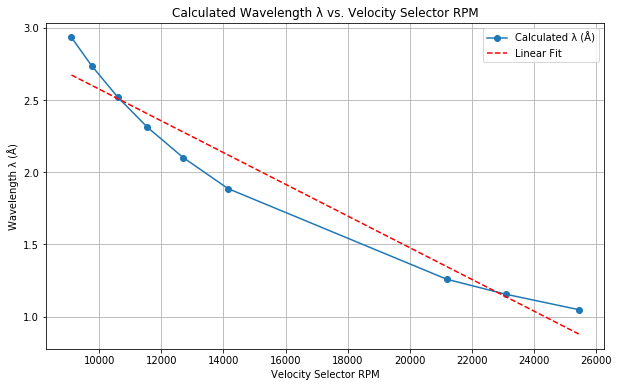

Fit parameters: a = -0.00010964694665490366, b = 3.6708289132748337


In [52]:
# Given data
rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100])
wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])

# Sorting the data
sorted_indices = np.argsort(rpm)
sorted_wavelengths = wavelengths[sorted_indices]
sorted_rpm = rpm[sorted_indices]

# Linear fit function
def linear_fit(x, a, b):
    return a / x + b

# Perform linear fit
popt, pcov = curve_fit(linear_fit, sorted_rpm, sorted_wavelengths)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sorted_rpm, sorted_wavelengths, 'o-', label='Given λ (Å)')
plt.plot(sorted_rpm, linear_fit(sorted_rpm, *popt), 'r--', label='Linear Fit')
plt.xlabel('Velocity Selector RPM')
plt.ylabel('Wavelength λ (Å)')
plt.title('Calculated Wavelength λ vs. Velocity Selector RPM')
plt.legend()
plt.grid(True)
plt.show()

# Print fit parameters
print(f"Fit parameters: a = {popt[0]}, b = {popt[1]}")


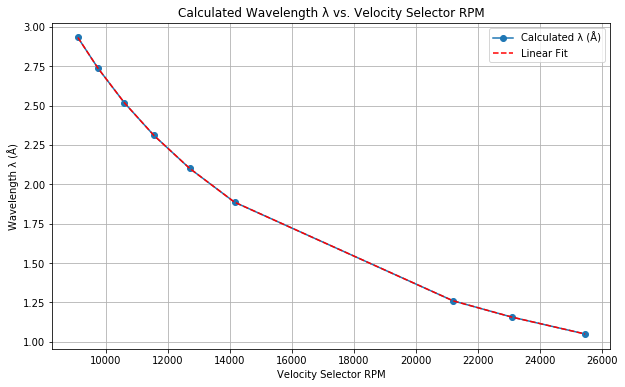

Fit parameters: a = 26690.000124452843, b = -8.10290973818246e-09


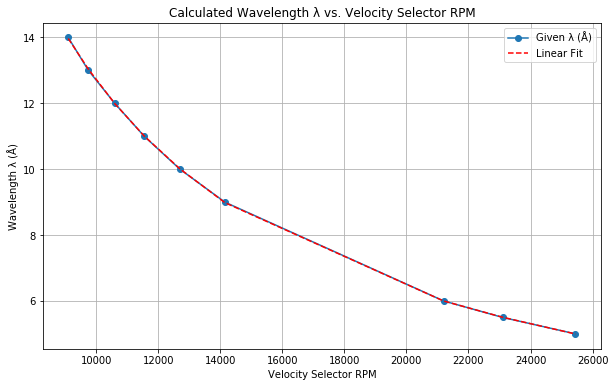

Fit parameters: a = 127085.57606353312, b = 0.0033461575973664543


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Given data
rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100])
wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])

# Sorting the data
sorted_indices = np.argsort(rpm)
sorted_wavelengths = wavelengths[sorted_indices]
sorted_rpm = rpm[sorted_indices]

# Calculate wavelengths
lambda_calculated = (2.669 * 10**4) / sorted_rpm

# Linear fit function
def linear_fit(x, a, b):
    return a / x + b

# Perform linear fit
popt, pcov = curve_fit(linear_fit, sorted_rpm, lambda_calculated)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sorted_rpm, lambda_calculated, 'o-', label='Calculated λ (Å)')
plt.plot(sorted_rpm, linear_fit(sorted_rpm, *popt), 'r--', label='Linear Fit')
plt.xlabel('Velocity Selector RPM')
plt.ylabel('Wavelength λ (Å)')
plt.title('Calculated Wavelength λ vs. Velocity Selector RPM')
plt.legend()
plt.grid(True)
plt.show()

# Print fit parameters
print(f"Fit parameters: a = {popt[0]}, b = {popt[1]}")

# Given data
rpm = np.array([25450, 23100, 21200, 14150, 12700, 11550, 10600, 9750, 9100])
wavelengths = np.array([5.0, 5.5, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])

# Sorting the data
sorted_indices = np.argsort(rpm)
sorted_wavelengths = wavelengths[sorted_indices]
sorted_rpm = rpm[sorted_indices]

# Linear fit function
def linear_fit(x, a, b):
    return a / x + b

# Perform linear fit
popt, pcov = curve_fit(linear_fit, sorted_rpm, sorted_wavelengths)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sorted_rpm, sorted_wavelengths, 'o-', label='Given λ (Å)')
plt.plot(sorted_rpm, linear_fit(sorted_rpm, *popt), 'r--', label='Linear Fit')
plt.xlabel('Velocity Selector RPM')
plt.ylabel('Wavelength λ (Å)')
plt.title('Calculated Wavelength λ vs. Velocity Selector RPM')
plt.legend()
plt.grid(True)
plt.show()

# Print fit parameters
print(f"Fit parameters: a = {popt[0]}, b = {popt[1]}")

# Load dataset


In [8]:
# Load data set(s)
# os.chdir('C:/Users/wbouwman/OneDrive - Delft University of Technology/Documents/Mydata/SANS')

os.chdir(r'C:\Users\Niels\Documents\AA Thesis\calibration')
print(glob.glob('*.mpa'))
files=glob.glob('*.mpa')
sampledata = dsans('sans0002961.mpa')
sampledata.load_distance()
# Load data and process it
sampledata.find_center_by_fwhm()

print(f"X Center: {sampledata.center_x}, X FWHM: {sampledata.fwhm_x}")
print(f"Y Center: {sampledata.center_y}, Y FWHM: {sampledata.fwhm_y}")
sampledata.convert_iq()

# Plot the 2D intensity data
sampledata.plot_2d()

# Calculate the absolute intensity
sampledata.calculate_absolute_intensity()

# Perform radial averaging on the absolute intensity
sampledata.radial_average_absolute_intensity()

# Print the calculated absolute intensities
print(f"Absolute Intensity: {sampledata.absolute_intensity}")

# Plot the 2D intensity data
sampledata.plot_2d_intensity()

# Plot the integrated intensity along x-axis (summed over y)
sampledata.plot_integrated_intensity(axis=0)

# Plot the integrated intensity along y-axis (summed over x)
sampledata.plot_integrated_intensity(axis=1)

# Plot the scattering cross section vs. q-value
sampledata.plot_scattering_cross_section()

sampledata.plot_qx_qy()



['sans0002961.mpa', 'sans000302.mpa', 'sans000308.mpa', 'sans000309.mpa']


AttributeError: 'dsans' object has no attribute 'load_distance'

# Calibration

# Divergence
not yet working


In [50]:
# # Calculate the beam size at each position
# #beam_sizes = sampledata.calculate_beam_size()

# # Calculate the total collimation length
# #total_length = sampledata.calculate_total_collimation_length()
# individual_distances = sampledata.get_individual_distances()

# # Calculate the beam divergence at each position
# beam_divergence = sampledata.calculate_beam_divergence()

# print(f"Individual Distances: {individual_distances}")
# print(f"Beam Sizes at Each Position: {beam_sizes}")
# print(f"Total Collimation Length: {total_length} mm")
# print(f"Beam Divergence at Each Position: {beam_divergence}")

# Plot 2D intensity data

In [ ]:
# Plot the 2D intensity data
#sampledata.plot_2d_intensity()

# Plot the integrated intensity along x-axis (summed over y)
sampledata.plot_integrated_intensity(axis=0)

# Plot the integrated intensity along y-axis (summed over x)
sampledata.plot_integrated_intensity(axis=1)

In [ ]:
# Plot the scattering cross section vs. q-value
sampledata.plot_scattering_cross_section()

In [ ]:
print(sampledata.q)
print(sampledata.absolute_intensity)

## finding centre function
not necessary rn

In [206]:
def find_center_by_fwhm(integrated_data):
    """
    Calculate the Full Width at Half Maximum (FWHM) to determine the center of the peak.

    Parameters:
    - integrated_data: 1D numpy array of integrated intensities along a specific axis.

    Returns:
    - fwhm: The full width at half maximum of the peak.
    - center_index: The index of the center of the peak.
    """
    # Find the maximum intensity
    max_intensity = np.max(integrated_data)

    # Calculate half of the maximum intensity
    half_max_intensity = max_intensity / 2

    # Find the indices where the intensity crosses half the maximum
    crossing_points = np.where(np.diff((integrated_data > half_max_intensity).astype(int)))[0]

    # Calculate FWHM and center if valid crossing points are found
    if len(crossing_points) >= 2:
        fwhm = crossing_points[-1] - crossing_points[0]
        center_index = (crossing_points[-1] + crossing_points[0]) / 2
    else:
        fwhm = None
        center_index = None
    return fwhm, center_index

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def find_and_fit_centre(detector_image, x_ranges, y_ranges, beam_stop_range_x, beam_stop_range_y):
    """
    Find the highest intensity peaks within specified regions, fit Gaussian curves to these
    peaks excluding the beam stop areas, and find the center of the detector.

    Parameters:
    - detector_image: 2D array representing the intensity across the detector
    - x_ranges: List of tuples defining the x regions to find peaks
    - y_ranges: List of tuples defining the y regions to find peaks
    - beam_stop_range_x: Tuple defining the beam stop range along the x-axis
    - beam_stop_range_y: Tuple defining the beam stop range along the y-axis

    Returns:
    - Dictionary with center coordinates and maximum intensities for both x and y directions
    """
    def find_highest_peaks(data, ranges):
        peaks = []
        intensities = []
        for start, end in ranges:
            if start >= len(data) or end > len(data):
                continue  # Skip this range if it's out of bounds
            region = data[start:end]
            max_index = np.argmax(region)
            peak = start + max_index
            peak_intensity = region[max_index]
            peaks.append(peak)
            intensities.append(peak_intensity)
        return peaks, intensities
     # Integrate the image data along x and y axes
    integrated_over_x = np.sum(detector_image, axis=1)  # Integration over x-axis (summing rows)
    integrated_over_y = np.sum(detector_image, axis=0)  # Integration over y-axis (summing columns)

    # Find peaks within specified ranges avoiding the beam stop areas
#    peaks_x, intensities_x = find_highest_peaks(integrated_over_x, x_ranges)
    def fit_gaussian_ignoring_beam_stop(coords, intensities, beam_stop_range):
        mask = (coords < beam_stop_range[0]) | (coords > beam_stop_range[1])
        x_fit = coords[mask]
        y_fit = intensities[mask]
        if not y_fit.size:
            return [0, 0, 1]  # Default parameters if no data to fit
        initial_guess = [max(y_fit), x_fit[np.argmax(y_fit)], np.std(x_fit) / 2]
        bounds = ([0, min(x_fit), 0], [np.inf, max(x_fit), np.inf])
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=initial_guess, bounds=bounds)
            return popt
        except RuntimeError:
            return [0, 0, 1]  # Default parameters if fitting fails

    # Gaussian fit to find exact centers
    popt_x = fit_gaussian_ignoring_beam_stop(np.arange(len(integrated_over_x)), integrated_over_x, beam_stop_range_x)
    popt_y = fit_gaussian_ignoring_beam_stop(np.arange(len(integrated_over_y)), integrated_over_y, beam_stop_range_y)

    return {
        'center_x': popt_x[1],
        'parameters_x': popt_x,
        'center_y': popt_y[1],
        'parameters_y': popt_y,
        'max_intensity_x': max(integrated_over_x, default=0),
        'max_intensity_y': max(integrated_over_y, default=0),
    }